# Diverse Graph Subgroup on Gaussian mixture

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import ot
import random
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy import linalg
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.linalg import sqrtm
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.stats import wasserstein_distance, wasserstein_distance_nd
from sklearn import svm
from k_means_constrained import KMeansConstrained

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## WHOMP Implementation

In [2]:
def PseudoBarycenter(dependent, sensitive, threshhold):
    X_mean = []
    X_cov = []
    OT_Map = []
    X_dim = dependent.shape[1]
    Z_range = len(set(sensitive))
    X_ave = np.average(dependent, axis = 0)

    for i in range(Z_range):
        X_mean.append(np.average(dependent[sensitive == i], axis = 0))
        X_cov.append(np.cov(dependent[sensitive == i].T))

    X_barcov = np.random.rand(X_dim,X_dim)
    eps = 1000
    while eps > threshhold:
        X_new = np.zeros((X_dim, X_dim))
        for i in range(Z_range):
            X_new = X_new + (1/Z_range) * sqrtm(sqrtm(X_barcov) @ X_cov[i] @ sqrtm(X_barcov))
        eps = np.linalg.norm(X_new - X_barcov)
        X_barcov = X_new

    X_bar = np.zeros(dependent.shape)
    for i in range(Z_range):
        transport = np.linalg.inv(sqrtm(X_cov[i])) @ sqrtm( sqrtm(X_cov[i]) @ X_barcov @ sqrtm(X_cov[i]) ) @ np.linalg.inv(sqrtm(X_cov[i]))
        OT_Map.append(transport)
        X_bar[sensitive == i] = (dependent[sensitive == i] - X_mean[i]) @ transport.T + X_ave

    return X_bar

def RandomPartition(X_toy, subgroup_number):
    random_index = np.zeros(len(X_toy))
    index = np.arange(len(X_toy))
    random.shuffle(index)
    random_subgroup = np.array_split(index, subgroup_number)
    for i in range(subgroup_number):
        random_index[random_subgroup[i]] = i
    return random_index

def Barycenter_Fixed_Point_LP(data, sensitive, threshhold):

    ## Initialization
    data_card, feature_dim = data.shape
    # Pick centroid as the overall average
    data_mean = np.average(data, axis = 0)
    sensitive_var_list = []
    sensitive_group_card_list = []
    # Pick variance as the smallest L2 norm among all sensitive groups
    sensitive_label = list(set(sensitive))
    sensitive_card = len(sensitive_label)
    for i in range(sensitive_card):
        sensitive_group = data[sensitive == sensitive_label[i],:]
        sensitive_group_card_list.append(sensitive_group.shape[0])
        sensitive_var_list.append(np.average(np.linalg.norm(sensitive_group,axis = 1)**2)**0.5)
    if len(set(sensitive_group_card_list)) > 1:
        return "Sensitive groups require to share the same cardinality."
        
    sensitive_group_card = sensitive_group_card_list[0]
    min_var = min(sensitive_var_list)
    # sample from Gaussian as initilization
    X_bar = np.random.multivariate_normal(data_mean, min_var*np.identity(feature_dim), sensitive_group_card)

    ## Iterative method to find the barycenter
    eps = threshhold + 1
    max_iter = 5000
    iter = 0
    while eps > threshhold and iter < max_iter:
        X_bar_new = np.zeros(X_bar.shape)
        X_bar_index = np.arange(sensitive_group_card)
        # Find the OT matching from X_bar to each sensitive group, then find the centroid of the matched points to update the barycenter
        match_list = []
        for i in range(sensitive_card):
            sensitive_group_index = np.where(sensitive == sensitive_label[i])[0]
            sensitive_group = data[sensitive_group_index,:]
            density_group = density_Xbar = np.ones(sensitive_group_card)
            cost_matrix = ot.dist(X_bar, sensitive_group)
            plan = np.array(ot.emd(density_Xbar, density_group, cost_matrix),dtype=int)
            match_index = plan @ X_bar_index
            match_list.append(sensitive_group_index[match_index])
            for j in range(sensitive_group_card):
                X_bar_new[j,:] += sensitive_group[match_index[j],:]
        X_bar_new = X_bar_new/sensitive_card

        # Update the distance between X_bar and the new one for the stop criteria
        cost_matrix_eps = ot.dist(X_bar, X_bar_new)
        plan_eps = np.array(ot.emd(density_Xbar/sensitive_group_card, density_group/sensitive_group_card, cost_matrix))
        eps = np.sqrt(np.sum(cost_matrix_eps*plan_eps))
        #var_Xbar = np.average(np.linalg.norm(X_bar, axis = 1)**2)**0.5
        #var_Xbar_new = np.average(np.linalg.norm(X_bar_new, axis = 1)**2)**0.5
        #eps = abs(var_Xbar - var_Xbar_new)
        iter += 1
        X_bar = X_bar_new
        match_list = (np.array(match_list)).T
    
    return X_bar, match_list

def WHOMP_LP(data, subgroup_number, threshold):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    barycenter, OT_plan_list = Barycenter_Fixed_Point_LP(data, label, threshold)
    matched_list = OT_plan_list
    return barycenter, matched_list

def RandomAntiClustering_Exact(data, subgroup_number):
    sample_size = data.shape[0]
    clf = KMeansConstrained(n_clusters= int(sample_size/subgroup_number),size_min=subgroup_number,size_max=subgroup_number,n_init = 500, max_iter = 10000, tol = 0.000000001, random_state=None)
    clf.fit_predict(data)
    label = clf.labels_
    anticluster_index = np.zeros(sample_size)-1
    for i in range(len(set(label))):
        index_i = np.where(label == i)[0]
        random.shuffle(index_i)
        index_i_select = np.array_split(index_i, subgroup_number)
        for j in range(subgroup_number):
            anticluster_index[index_i_select[j]] = j

    return anticluster_index

## Pocock and Simon's Covariate-adaptive Randomizatiom Implementation

In [3]:
class PocockSimonsMinimizationMultiTreatment:
    def __init__(self, covariates, treatments, num_treatments, imbalance_prob=0.8):
        """
        Initializes the Pocock and Simon's minimization class for multiple treatments.

        Parameters:
        - covariates: List of tuples containing the covariate values for each subject so far.
        - treatments: List containing the treatment assignments (integers starting from 0) for each subject so far.
        - num_treatments: The number of treatment groups.
        - imbalance_prob: Probability of assigning to the treatment that minimizes imbalance (default 0.8).
        """
        self.covariates = np.array(covariates)
        self.treatments = np.array(treatments)
        self.num_treatments = num_treatments
        self.imbalance_prob = imbalance_prob

    def calculate_imbalance_score(self, treatment, new_covariate):
        """
        Calculate imbalance score for a given potential treatment assignment.

        Parameters:
        - treatment: Treatment group being evaluated (integer starting from 0).
        - new_covariate: Covariates of the new subject.

        Returns:
        - Imbalance score.
        """
        imbalance_score = 0

        # Iterate over each covariate
        for i in range(self.covariates.shape[1]):
            treatment_sums = []
            for t in range(self.num_treatments):
                existing_sum = np.sum(self.covariates[self.treatments == t, i])
                if t == treatment:
                    existing_sum += new_covariate[i]
                treatment_sums.append(existing_sum)
            
            # Calculate imbalance as the range (max - min) of sums
            imbalance_score += max(treatment_sums) - min(treatment_sums)

        return imbalance_score

    def assign_treatment(self, new_covariate):
        """
        Assign treatment to a new subject based on Pocock and Simon's method with multiple treatments.

        Parameters:
        - new_covariate: Covariates of the new subject.

        Returns:
        - Treatment assignment (integer representing the treatment group).
        """
        imbalance_scores = []
        
        # Calculate imbalance scores for each possible treatment group
        for t in range(self.num_treatments):
            imbalance_score = self.calculate_imbalance_score(t, new_covariate)
            imbalance_scores.append(imbalance_score)
        
        # Find the treatment with the minimum imbalance score
        min_score = min(imbalance_scores)
        min_treatments = [t for t, score in enumerate(imbalance_scores) if score == min_score]
        
        if len(min_treatments) == 1:
            best_treatment = min_treatments[0]
        else:
            best_treatment = np.random.choice(min_treatments)  # Randomly choose among the best
        
        # Assign with imbalance_prob to the best treatment, otherwise to a random one
        if np.random.rand() < self.imbalance_prob:
            return best_treatment
        else:
            return np.random.choice(range(self.num_treatments))
        
class MinimizationAlgorithm:
    def __init__(self, num_treatments, max_group_size):
        self.num_treatments = num_treatments
        self.max_group_size = max_group_size
        self.group_sizes = np.zeros(num_treatments)
    
    def assign_treatment(self, covariate, group, treatment):
        # Pocock-Simon minimization logic, adding constraint for group sizes
        # Example placeholder (modify with actual minimization logic)
        eligible_treatments = [i for i in range(self.num_treatments) if self.group_sizes[i] < self.max_group_size]
        if not eligible_treatments:
            raise ValueError("All groups are full.")

        # Minimize discrepancy for eligible treatments
        # Here you would calculate imbalance for eligible treatments
        assigned_treatment = random.choice(eligible_treatments)  # Replace this with minimization logic
        
        # Update the group sizes
        self.group_sizes[assigned_treatment] += 1
        return assigned_treatment

def Pocock_Simon_minimization(covariates, num_treatments):
    treatment_assignment = np.zeros(covariates.shape[0], dtype=int)
    index_shuffle = np.arange(covariates.shape[0])
    random.shuffle(index_shuffle)
    
    # Set the maximum group size for balanced groups
    max_group_size = covariates.shape[0] // num_treatments
    
    # Initialize treatment assignments for the first few participants
    ini_treatment = np.arange(num_treatments)
    treatment_assignment[index_shuffle[:num_treatments]] = ini_treatment
    
    # Create the minimization algorithm instance with group size enforcement
    minimization = MinimizationAlgorithm(num_treatments=num_treatments, max_group_size=max_group_size)
    
    # Update the group sizes for the initial assignments
    minimization.group_sizes += 1  # As each treatment got 1 participant
    
    # Start assigning the rest of the participants
    for i in range(num_treatments, covariates.shape[0]):
        # Subset of participants assigned so far
        treatment = treatment_assignment[index_shuffle[:i]]
        group = covariates[index_shuffle[:i], :]
        
        # Assign the next participant, enforcing group size balancing
        assigned_treatment = minimization.assign_treatment(covariates[index_shuffle[i], :], group, treatment)
        treatment_assignment[index_shuffle[i]] = assigned_treatment
    
    return treatment_assignment


## Comparison Test Implementation

In [4]:
def HoldoutSet(X, y, holdoutindex):
    X_holdout = X[holdoutindex == 1]
    X_comp = X[holdoutindex != 1]
    y_holdout = y[holdoutindex == 1]
    y_comp = y[holdoutindex != 1]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex == shuffle[0]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex == shuffle[0]]
    return X_holdout, X_comp, y_holdout, y_comp

def RandomSubgroupSet_Complement(X, y, subgroupindex):
    shuffle = np.arange((len(set(subgroupindex))))
    random.shuffle(shuffle)
    X_holdout = X[subgroupindex == shuffle[1]]
    X_comp = X[subgroupindex != shuffle[1]]
    y_holdout = y[subgroupindex == shuffle[1]]
    y_comp = y[subgroupindex != shuffle[1]]
    return X_holdout, X_comp, y_holdout, y_comp

## Visualization

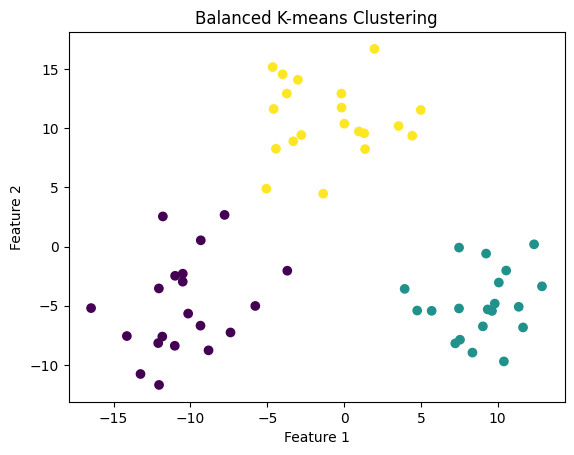

In [5]:
X_toy, truth_model = make_blobs(n_samples=60, centers= [(0,10), (-10,-5), (10,-5)], cluster_std = [3,3,3])

clf = KMeansConstrained(n_clusters= 3,size_min=20,size_max=20,random_state=0)
clf.fit_predict(X_toy)

# Plot results
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=clf.labels_, cmap='viridis', marker='o')
plt.title('Balanced K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

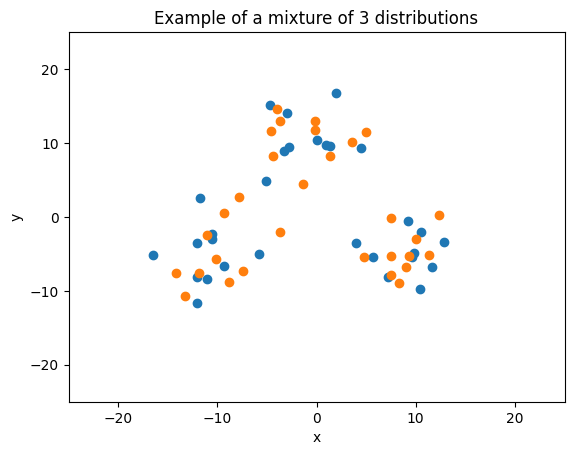

In [6]:
anti_index = RandomAntiClustering_Exact(X_toy, 2)
for i in range(3):
    plt.scatter(X_toy[np.where(anti_index == i)[0],0], X_toy[np.where(anti_index == i)[0],1])
plt.title(f"Example of a mixture of {3} distributions")
plt.xlabel("x")
plt.ylabel("y");
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('distributions.png')

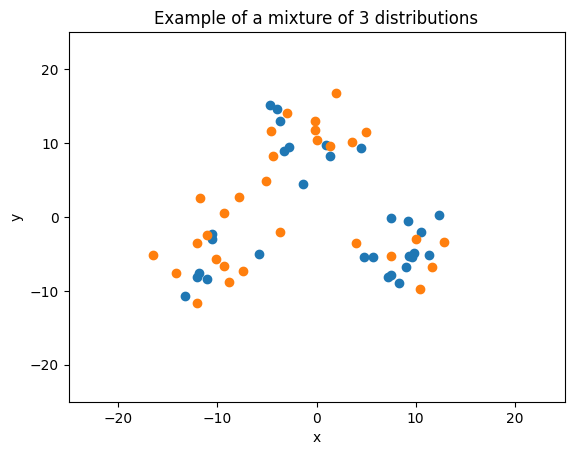

In [7]:
PS_index = Pocock_Simon_minimization(X_toy, 2)
for i in range(3):
    plt.scatter(X_toy[np.where(PS_index == i)[0],0], X_toy[np.where(PS_index == i)[0],1])
plt.title(f"Example of a mixture of {3} distributions")
plt.xlabel("x")
plt.ylabel("y");
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('distributions.png')

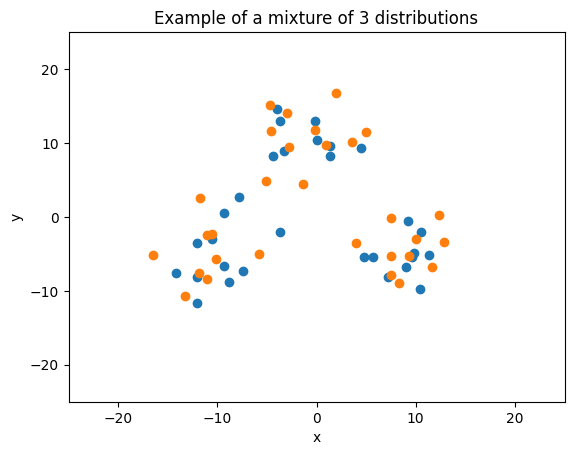

In [8]:
barycenter, barysample_index = WHOMP_LP(X_toy, 2, 0.0000001)
for i in range(2):
    X = np.concatenate([X_toy[barysample_index[i],:], np.expand_dims(barycenter[i,:], axis = 0)], axis = 0)
    plt.scatter(X_toy[barysample_index[i],0], X_toy[barysample_index[i],1])
plt.title(f"Example of a mixture of {3} distributions")
plt.xlabel("x")
plt.ylabel("y");
plt.xlim(-25, 25)
plt.ylim(-25, 25)
plt.savefig('distributions.png')

## Wasserstein Experiment

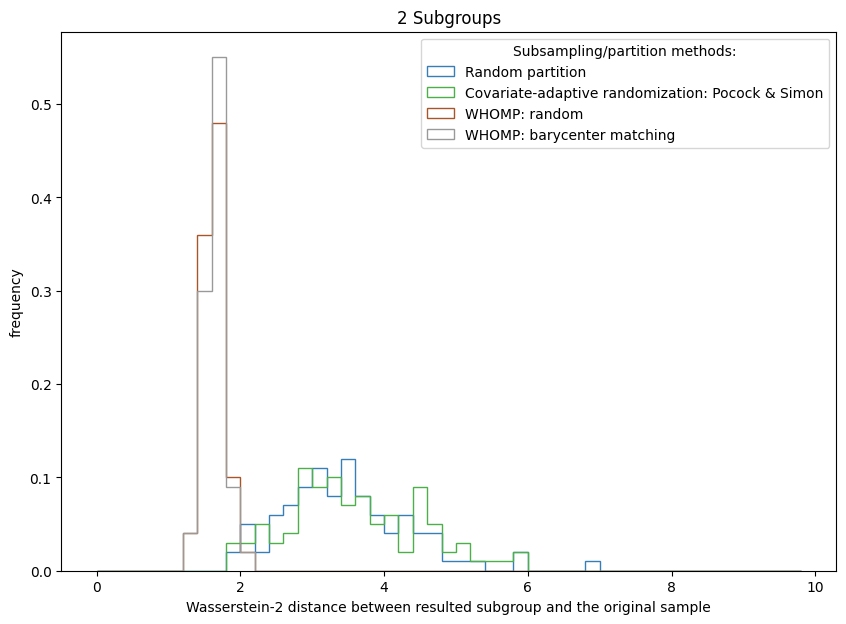

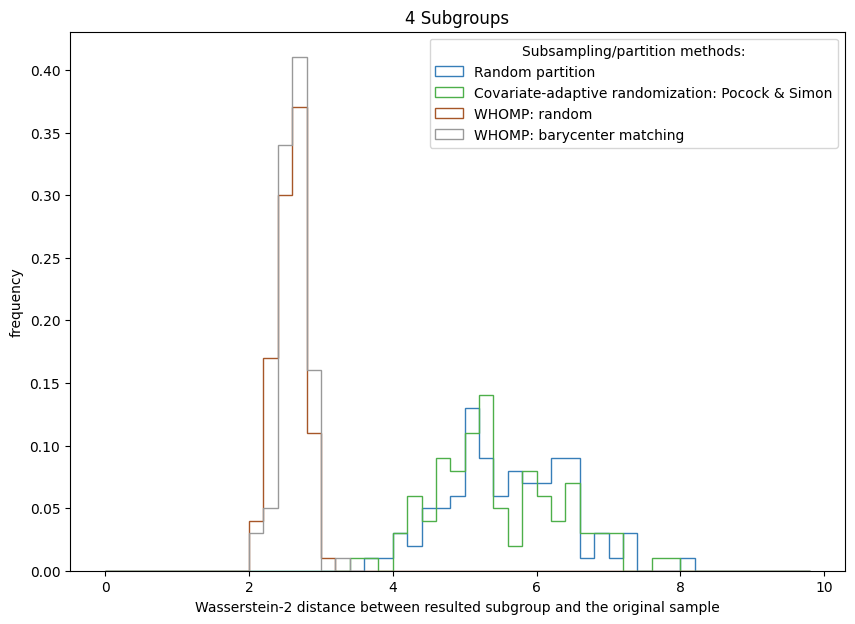

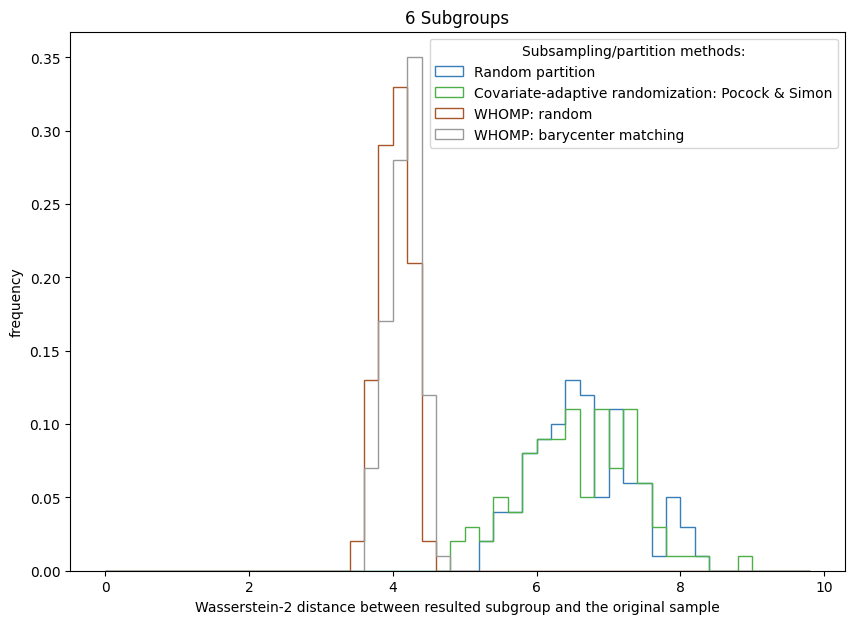

In [9]:
random_error_ave = []
PS_error_ave = []
anticluster_error_ave = []
WHOMP_error_ave = []

random_error_std = []
PS_error_std = []
anticluster_error_std = []
WHOMP_error_std = []

random_error_list = []
PS_error_list = []
anticluster_error_list = []
WHOMP_error_list = []

random_mean_list = []
PS_mean_list = []
anti_mean_list = []
bary_mean_list = []

random_var_list = []
PS_var_list = []
anti_var_list = []
bary_var_list = []

for k in range(2,7,2):

    random_error = []
    PS_error = []
    anticluster_error = []
    WHOMP_error = []

    mean_random = []
    var_random = []

    mean_PS = []
    var_PS = []

    mean_anti = []
    var_anti = []

    mean_bary = []
    var_bary = []

    for s in range(100):

        X_toy, truth_model = make_blobs(n_samples=60, centers= [(0,10), (-10,-5), (10,-5)], cluster_std = [3, 3, 3])
        #X_toy, truth_model = make_blobs(n_samples=480, centers= [(0,5), (-5,-2.5), (5,-2.5), (5,-5), (2.5,-5), (0,-5)], cluster_std = [1,1,1,1,1,1], random_state=42) 
        subgroup_number = k

        barycenter, barysample_index = WHOMP_LP(X_toy, subgroup_number , 0.00000001)
        PS_index = Pocock_Simon_minimization(X_toy, subgroup_number)
        anticluster_index = RandomAntiClustering_Exact(X_toy, subgroup_number=subgroup_number)
        random_index = RandomPartition(X_toy, subgroup_number=subgroup_number)

        X_bary = X_toy[barysample_index[0],:]
        density_sensitive = np.ones(X_bary.shape[0])/X_bary.shape[0]
        density_X = np.ones(X_toy.shape[0])/X_toy.shape[0]
        
        eps_random = 0
        for i in range(subgroup_number):
            X_random = X_toy[random_index == i,:]
            cost_matrix_random = ot.dist(X_toy, X_random)
            plan_random = np.array(ot.emd(density_X, density_sensitive, cost_matrix_random))
            eps_random += np.sum(cost_matrix_random*plan_random)
            mean_random.append(np.average(X_random))
            var_random.append(np.var(X_random))


        eps_PS = 0
        for i in range(subgroup_number):
            X_ps = X_toy[PS_index == i,:]
            cost_matrix_PS = ot.dist(X_toy, X_ps)
            plan_PS = np.array(ot.emd(density_X, density_sensitive, cost_matrix_PS))
            eps_PS += np.sum(cost_matrix_PS*plan_PS)
            mean_PS.append(np.average(X_ps))
            var_PS.append(np.var(X_ps))
        
        
        eps_anti = 0
        for i in range(subgroup_number):
            X_anti = X_toy[anticluster_index == i,:]
            cost_matrix_anti = ot.dist(X_toy, X_anti)
            plan_anti = np.array(ot.emd(density_X, density_sensitive, cost_matrix_anti))
            eps_anti += np.sum(cost_matrix_anti*plan_anti)
            mean_anti.append(np.average(X_anti))
            var_anti.append(np.var(X_anti))

        
        eps_bary = 0
        for i in range(subgroup_number):
            X_bary = X_toy[barysample_index[i],:]
            cost_matrix_bary = ot.dist(X_toy, X_bary)
            plan_bary = np.array(ot.emd(density_X, density_sensitive, cost_matrix_bary))
            eps_bary += np.sum(cost_matrix_bary*plan_bary)
            mean_bary.append(np.average(X_bary))
            var_bary.append(np.var(X_bary))

        random_error.append(np.sqrt(eps_random/subgroup_number))
        PS_error.append(np.sqrt(eps_PS/subgroup_number))
        anticluster_error.append(np.sqrt(eps_anti/subgroup_number))
        WHOMP_error.append(np.sqrt(eps_bary/subgroup_number))

    random_error_list.append(random_error)
    PS_error_list.append(PS_error)
    anticluster_error_list.append(anticluster_error)
    WHOMP_error_list.append(WHOMP_error)
 
    random_error_ave.append(np.average(random_error))
    PS_error_ave.append(np.average(PS_error))
    anticluster_error_ave.append(np.average(anticluster_error))
    WHOMP_error_ave.append(np.average(WHOMP_error))

    random_error_std.append(np.std(random_error))
    PS_error_std.append(np.std(PS_error))
    anticluster_error_std.append(np.std(anticluster_error))
    WHOMP_error_std.append(np.std(WHOMP_error))

    random_mean_list.append(mean_random)
    PS_mean_list.append(mean_PS)
    anti_mean_list.append(mean_anti)
    bary_mean_list.append(mean_bary)

    random_var_list.append(var_random)
    PS_var_list.append(var_PS)
    anti_var_list.append(var_anti)
    bary_var_list.append(var_bary)

    fig = plt.figure(figsize =(10, 7))
    xbins = np.arange(0, 10, 0.2)
 
    plt.hist(random_error, bins = xbins, density=False, weights= 1/len(random_error) * np.ones(len(random_error)), histtype='step', color = '#377eb8', label='Random partition')
    plt.hist(PS_error, bins = xbins, density=False, weights= 1/len(PS_error) * np.ones(len(PS_error)), histtype='step', color = '#4daf4a', label='Covariate-adaptive randomization: Pocock & Simon')
    plt.hist(anticluster_error, bins = xbins, density=False, weights= 1/len(anticluster_error) * np.ones(len(anticluster_error)), histtype='step', color = '#a65628', label='WHOMP: random')
    plt.hist(WHOMP_error, bins = xbins, density=False, weights= 1/len(WHOMP_error) * np.ones(len(WHOMP_error)), histtype='step', color = '#999999', label='WHOMP: barycenter matching')

    plt.xlabel('W2 distance between resulting subgroup and original sample', fontsize = 18)
    plt.ylabel('frequency', fontsize = 18)
    plt.legend(fontsize=15, title='Subsampling/partition methods:')

    plt.title("{} Subgroups".format(k)) 
 
    # show plot
    plt.show()

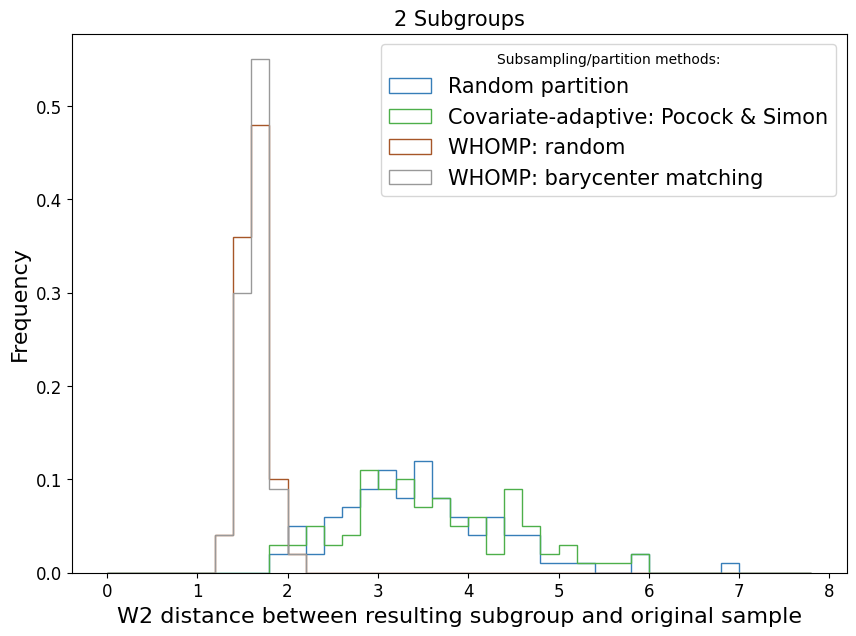

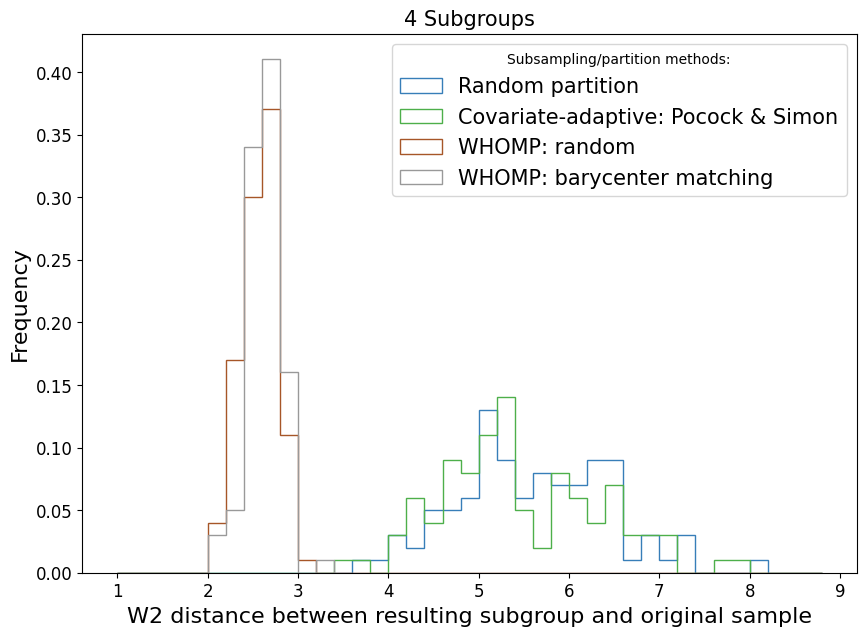

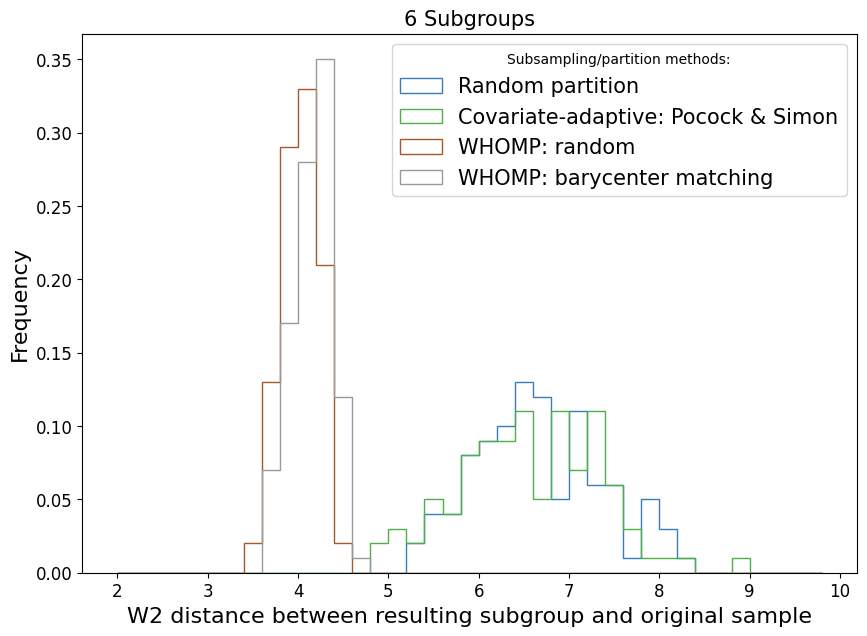

In [61]:
for i in range(0,3):
    k = (i+1)*2

    fig = plt.figure(figsize =(10, 7))
    xbins = np.arange(0+i, 8+i, 0.2)

    random_error = random_error_list[i]
    PS_error = PS_error_list[i]
    anticluster_error = anticluster_error_list[i]
    WHOMP_error = WHOMP_error_list[i]
 
    plt.hist(random_error, bins = xbins, density=False, weights= 1/len(random_error) * np.ones(len(random_error)), histtype='step', color = '#377eb8', label='Random partition')
    plt.hist(PS_error, bins = xbins, density=False, weights= 1/len(PS_error) * np.ones(len(PS_error)), histtype='step', color = '#4daf4a', label='Covariate-adaptive: Pocock & Simon')
    plt.hist(anticluster_error, bins = xbins, density=False, weights= 1/len(anticluster_error) * np.ones(len(anticluster_error)), histtype='step', color = '#a65628', label='WHOMP: random')
    plt.hist(WHOMP_error, bins = xbins, density=False, weights= 1/len(WHOMP_error) * np.ones(len(WHOMP_error)), histtype='step', color = '#999999', label='WHOMP: barycenter matching')

    plt.xlabel('W2 distance between resulting subgroup and original sample', fontsize = 16)
    plt.ylabel('Frequency', fontsize = 16)
    plt.legend(fontsize=15, title='Subsampling/partition methods:')
    plt.tick_params(axis='both', labelsize=12)

    plt.title("{} Subgroups".format(k), fontsize = 15) 
 
    # show plot
    plt.show()
    

In [10]:
random_error_ave, PS_error_ave, anticluster_error_ave, WHOMP_error_ave

([3.4812896389383865, 5.600438176944489, 6.664769357290527],
 [3.588906937525335, 5.4693366876660585, 6.5661397280683875],
 [1.641896980484204, 2.575144801813612, 4.028974223452976],
 [1.6507002585791397, 2.63383160144848, 4.169582893160285])

In [11]:
random_error_std, PS_error_std, anticluster_error_std, WHOMP_error_std

([0.8899704558904135, 0.8489733192739624, 0.692493165428418],
 [0.9394171869978258, 0.8860196315726041, 0.7713091744591605],
 [0.1456088356929704, 0.19978243770013573, 0.21061110503905062],
 [0.1450868239500623, 0.1985478220680832, 0.22544100406145853])

In [26]:
for i in range(3):
    print((np.var(np.array(bary_mean_list[i])), np.var(np.array(anti_mean_list[i])), np.var(np.array(PS_mean_list[i])), np.var(np.array(random_mean_list[i]))))

(0.19894688480373746, 0.09341614810874603, 0.6286785359705439, 0.6506621235171894)
(0.5553309998386206, 0.1298414953417694, 1.7867780277375334, 2.1467084440066975)
(1.3579777436414782, 0.30245849115653056, 2.872556846842597, 2.9904594825607216)


In [27]:
for i in range(3):
    print((np.var(np.array(bary_var_list[i])), np.var(np.array(anti_var_list[i])), np.var(np.array(PS_var_list[i])), np.var(np.array(random_var_list[i]))))

(21.725452444808266, 23.42232756393173, 40.92946410994688, 33.37645795093468)
(27.9723250520939, 35.380511599087185, 80.22110041736218, 80.66068765117811)
(36.98830504060442, 57.63773585055841, 129.88541611712927, 134.74236024152486)


## Downstream Task: Logistic Regression

In [14]:
def logistic_regression_Gaussian_mixture_experiment(subgroup_number, repetition):
    random_error = []
    PS_error = []
    WHOMP_random_error = []
    WHOMP_matching_error = []
    
    for s in range(repetition):
        # data from mixture of Gaussians
        X_toy, truth_model = make_blobs(n_samples=60, centers=[(0,10), (-10,-5), (10,-5)], cluster_std = [4, 4, 4], random_state=42)
                        
        barycenter, barysample_index = WHOMP_LP(X_toy, subgroup_number , 0.0000001)
        shuffle_index = np.arange(subgroup_number)
        np.random.shuffle(shuffle_index)
        X_WHOMP_matching = X_toy[barysample_index[shuffle_index[0]],:]
        X_WHOMP_matching_comp = X_toy[barysample_index[shuffle_index[1]],:]
        y_WHOMP_matching = truth_model[barysample_index[shuffle_index[0]]]
        y_WHOMP_matching_comp = truth_model[barysample_index[shuffle_index[1]]]

        PS_index = Pocock_Simon_minimization(X_toy, subgroup_number)
        X_PS, X_PS_comp, y_PS, y_PS_comp = RandomSubgroupSet(X_toy, truth_model, PS_index)

        WHOMP_random_index = RandomAntiClustering_Exact(X_toy, subgroup_number=subgroup_number)
        X_WHOMP_random, X_WHOMP_random_comp, y_WHOMP_random, y_WHOMP_random_comp = RandomSubgroupSet(X_toy, truth_model, WHOMP_random_index)

        random_index = RandomPartition(X_toy, subgroup_number=subgroup_number)
        X_sample, X_sample_comp, y_sample, y_sample_comp = RandomSubgroupSet(X_toy, truth_model, random_index)

        clf_random = LogisticRegression(random_state=0).fit(X_sample, y_sample)
        clf_PS = LogisticRegression(random_state=0).fit(X_PS, y_PS)
        clf_WHOMP_random = LogisticRegression(random_state=0).fit(X_WHOMP_random, y_WHOMP_random)
        clf_WHOMP_matching = LogisticRegression(random_state=0).fit(X_WHOMP_matching, y_WHOMP_matching)
        random_error.append( clf_random.score(X_sample_comp, y_sample_comp))
        PS_error.append(clf_PS.score(X_PS_comp,y_PS_comp))
        WHOMP_random_error.append(clf_WHOMP_random.score(X_WHOMP_random_comp,y_WHOMP_random_comp))
        WHOMP_matching_error.append(clf_WHOMP_matching.score(X_WHOMP_matching_comp, y_WHOMP_matching_comp))
    
    return random_error, PS_error, WHOMP_random_error, WHOMP_matching_error


In [15]:
error_list = []
std_list = []

for i in range(3):
    subgroup_number = (i+1)*2
    random_error, PS_error, WHOMP_random_error, WHOMP_matching_error = logistic_regression_Gaussian_mixture_experiment(subgroup_number, 100)

    error_list.append((np.average(random_error), np.average(PS_error), np.average(WHOMP_random_error), np.average(WHOMP_matching_error)))
    std_list.append((np.std(random_error), np.std(PS_error), np.std(WHOMP_random_error), np.std(WHOMP_matching_error)))


In [16]:
for i in range(3):
    print(np.array(error_list)[i,:])

[0.98133333 0.97866667 0.98466667 0.983     ]
[0.98266667 0.97133333 0.982      0.97666667]
[0.944 0.95  0.98  0.984]


In [17]:
for i in range(3):
    print(np.array(std_list)[i,:])

[0.02276449 0.01733333 0.01661325 0.01666333]
[0.03213859 0.04546549 0.0295973  0.03179797]
[0.11689311 0.0728011  0.04       0.03666061]


## Downstream Task: SVM

In [18]:
def SVM_Gaussian_mixture_experiment(subgroup_number, repetition):
    random_error = []
    PS_error = []
    WHOMP_random_error = []
    WHOMP_matching_error = []
    
    for s in range(repetition):
        # data from mixture of Gaussians
        X_toy, truth_model = make_blobs(n_samples=60, centers=[(0,10), (-10,-5), (10,-5)], cluster_std = [4, 2, 2], random_state=42)
    
        barycenter, barysample_index = WHOMP_LP(X_toy, subgroup_number , 0.0000001)
        shuffle_index = np.arange(subgroup_number)
        np.random.shuffle(shuffle_index)
        X_WHOMP_matching = X_toy[barysample_index[shuffle_index[0]],:]
        X_WHOMP_matching_comp = X_toy[barysample_index[shuffle_index[1]],:]
        y_WHOMP_matching = truth_model[barysample_index[shuffle_index[0]]]
        y_WHOMP_matching_comp = truth_model[barysample_index[shuffle_index[1]]]

        PS_index = Pocock_Simon_minimization(X_toy, subgroup_number)
        X_PS, X_PS_comp, y_PS, y_PS_comp = RandomSubgroupSet(X_toy, truth_model, PS_index)

        WHOMP_random_index = RandomAntiClustering_Exact(X_toy, subgroup_number=subgroup_number)
        X_WHOMP_random, X_WHOMP_random_comp, y_WHOMP_random, y_WHOMP_random_comp = RandomSubgroupSet(X_toy, truth_model, WHOMP_random_index)

        random_index = RandomPartition(X_toy, subgroup_number=subgroup_number)
        X_sample, X_sample_comp, y_sample, y_sample_comp = RandomSubgroupSet(X_toy, truth_model, random_index)

        clf_random = svm.SVC().fit(X_sample, y_sample)
        clf_PS = svm.SVC().fit(X_PS, y_PS)
        clf_WHOMP_random = svm.SVC().fit(X_WHOMP_random, y_WHOMP_random)
        clf_WHOMP_matching = svm.SVC().fit(X_WHOMP_matching, y_WHOMP_matching)
        random_error.append( clf_random.score(X_sample_comp, y_sample_comp))
        PS_error.append(clf_PS.score(X_PS_comp,y_PS_comp))
        WHOMP_random_error.append(clf_WHOMP_random.score(X_WHOMP_random_comp,y_WHOMP_random_comp))
        WHOMP_matching_error.append(clf_WHOMP_matching.score(X_WHOMP_matching_comp, y_WHOMP_matching_comp))
    
    return random_error, PS_error, WHOMP_random_error, WHOMP_matching_error
    

In [19]:
error_list_SVM = []
std_list_SVM = []

for i in range(3):
    subgroup_number = (i+1)*2
    random_error, PS_error, WHOMP_random_error, WHOMP_matching_error = SVM_Gaussian_mixture_experiment(subgroup_number, 100)

    error_list_SVM.append((np.average(random_error), np.average(PS_error), np.average(WHOMP_random_error), np.average(WHOMP_matching_error)))
    std_list_SVM.append((np.std(random_error), np.std(PS_error), np.std(WHOMP_random_error), np.std(WHOMP_matching_error)))

In [20]:
for i in range(3):
    print(np.array(error_list_SVM)[i,:])

[1. 1. 1. 1.]
[0.99333333 0.998      1.         1.        ]
[0.987 0.982 0.999 1.   ]


In [21]:
for i in range(3):
    print(np.array(std_list_SVM)[i,:])

[0. 0. 0. 0.]
[0.05374838 0.01989975 0.         0.        ]
[0.05413871 0.06063003 0.00994987 0.        ]


## Downstream Task: Linear Regression

In [22]:
def LinearRegression_Gaussian_mixture_experiment(subgroup_number, repetition):
    random_error = []
    PS_error = []
    WHOMP_random_error = []
    WHOMP_matching_error = []
    
    for s in range(repetition):
        # data from mixture of Gaussians
        X_toy, truth_model = make_blobs(n_samples=60, centers=[(0,10), (-10,-5), (10,-5)], cluster_std = [4, 2, 2], random_state=42)
    
        barycenter, barysample_index = WHOMP_LP(X_toy, subgroup_number , 0.0000001)
        shuffle_index = np.arange(subgroup_number)
        np.random.shuffle(shuffle_index)
        X_WHOMP_matching = X_toy[barysample_index[shuffle_index[0]],:]
        X_WHOMP_matching_comp = X_toy[barysample_index[shuffle_index[1]],:]
        y_WHOMP_matching = truth_model[barysample_index[shuffle_index[0]]]
        y_WHOMP_matching_comp = truth_model[barysample_index[shuffle_index[1]]]

        PS_index = Pocock_Simon_minimization(X_toy, subgroup_number)
        X_PS, X_PS_comp, y_PS, y_PS_comp = RandomSubgroupSet(X_toy, truth_model, PS_index)

        WHOMP_random_index = RandomAntiClustering_Exact(X_toy, subgroup_number=subgroup_number)
        X_WHOMP_random, X_WHOMP_random_comp, y_WHOMP_random, y_WHOMP_random_comp = RandomSubgroupSet(X_toy, truth_model, WHOMP_random_index)

        random_index = RandomPartition(X_toy, subgroup_number=subgroup_number)
        X_sample, X_sample_comp, y_sample, y_sample_comp = RandomSubgroupSet(X_toy, truth_model, random_index)

        clf_random = LinearRegression().fit(X_sample[:,0].reshape(-1,1), X_sample[:,1])
        clf_PS = LinearRegression().fit(X_PS[:,0].reshape(-1,1), X_PS[:,1])
        clf_WHOMP_random = LinearRegression().fit(X_WHOMP_random[:,0].reshape(-1,1), X_WHOMP_random[:,1])
        clf_WHOMP_matching = LinearRegression().fit(X_WHOMP_matching[:,0].reshape(-1,1), X_WHOMP_matching[:,1])

        pred_random = clf_random.predict(X_sample_comp[:,0].reshape(-1,1))
        pred_PS = clf_PS.predict(X_PS_comp[:,0].reshape(-1,1))
        pred_WHOMP_random = clf_WHOMP_random.predict(X_WHOMP_random_comp[:,0].reshape(-1,1))
        pred_WHOMP_matching = clf_WHOMP_matching.predict(X_WHOMP_matching_comp[:,0].reshape(-1,1))

        random_error.append(np.linalg.norm(pred_random - X_sample_comp[:,1])/len(pred_random))
        PS_error.append(np.linalg.norm(pred_PS - X_PS_comp[:,1])/len(pred_PS))
        WHOMP_random_error.append(np.linalg.norm(pred_WHOMP_random - X_WHOMP_random_comp[:,1])/len(pred_WHOMP_random))
        WHOMP_matching_error.append(np.linalg.norm(pred_WHOMP_matching - X_WHOMP_matching_comp[:,1])/len(pred_WHOMP_matching))
    
    return random_error, PS_error, WHOMP_random_error, WHOMP_matching_error


In [23]:
error_list_LR = []
std_list_LR = []

for i in range(3):
    subgroup_number = (i+1)*2
    random_error, PS_error, WHOMP_random_error, WHOMP_matching_error = LinearRegression_Gaussian_mixture_experiment(subgroup_number, 100)

    error_list_LR.append((np.average(random_error), np.average(PS_error), np.average(WHOMP_random_error), np.average(WHOMP_matching_error)))
    std_list_LR.append((np.std(random_error), np.std(PS_error), np.std(WHOMP_random_error), np.std(WHOMP_matching_error)))

In [24]:
for i in range(3):
    print(np.array(error_list_LR)[i,:])

[1.3551581  1.35099291 1.29131664 1.30892763]
[1.94270065 1.98816415 1.8753863  1.86146426]
[2.54845359 2.38310397 2.28201409 2.32010953]


In [25]:
for i in range(3):
    print(np.array(std_list_LR)[i,:])

[0.11163029 0.1053173  0.03433654 0.04199508]
[0.29795244 0.34314714 0.14177289 0.17080448]
[0.56344227 0.36980857 0.21271363 0.22953836]
